# Nonlinear Regression

This notebook will develop some relatively advanced approaches for solving more challenging optimization problems; specifically, we consider problems where there is no analytical solution for model predictions. In these cases, we must use numerical methods to evaluate the objective function. It is not apparent yet, but this means that our solutions will involve two numerical methods--one to solve the objective function, and one to optimize the objective function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
import pandas as pd

## Nonlinear Least Squares Recap:

We should have a good feel for least squares analysis at this point. So far, we have used both linear least squares and nonlinear least squares to find determine rate laws and estimate kinetic parameters. Today, we will use nonlinear least squares exclusively. The basic problem in kinetic analysis usually involves having aa single model that describes an observable quantity in our reactor. For example, below we have the solution for $C_A(t)$ in the case of a single, first order, irreversible reaction in a constant volume batch reactor:

$$C_A = C_{A0}e^{-kt}$$

We would like to apply this model to our measured data. In this case, our measurements would be the concentration of $A$, $C_A$ as a function of $t$. When we perform an experiment, we might generate 10, 20, 50, or more $(C_A, t)$ pairs, and we would like our model to predict all of them. This is an inverse, data anlysis problem, so when we formulate the system, we will have many equations (10, 20, 50, or more -- one equation per measurement), but we will only have a few unknowns. In this case, our single unknown parameter is the rate constant $k$. In theory, this model equation should be satisfied for all data points, but in practice, this is never true. The system is overdetermined (e.g., 50 independent equations, 1 unknown), and experimental errors mean that there is no unique solution.  Instead, we have to find the *best* values of the parameters of interest. In our context, the *best* value is the one that minimizes the total sum of square errors between our measurement and our model's prediction.

$$SSE = \sum_i(y_i - \hat{y}_i)^2$$

No matter what problem you are trying to solve, the method behind nonlinear least squares is always the same:

1. Propose a model that includes your variable parameters (e.g., a rate constant or reaction order)
2. Use that model to calculate the value of your measurable quantity at each experimental condition (e.g., a concentration at a specific time)
3. Calculate the square error between your measurement and the value predicted by your model
4. Sum the square errors for each data point.
5. Use an iterative solver to vary the parameters of interest until the sum of square errors is at a minimum.

## Example Problem 01

We want to determine the rate constant for the following reaction:

$$A \longrightarrow B$$

For this experiment, we use a constant volume batch reactor, and we know a few things about the reaction.  First, the rate of reaction is first order in species $A$. Second, the rate is independent of the concentration of $B$. Based on the above, we write the following rate law:

$$r = kC_A$$

Finally, the concentration of $A$ at the start of the experiment was quantified very precisely.  We know that it is equal to $C_{A0} = 15 \mathrm{M}$. Otherwise, the only information that we have is that we measured the concentration of the reactant, $C_A$, as a function of reaction time. The data are compiled in separate CSV files, `t1.csv` and `C1.csv`. We will import this data and then convert it into numpy arrays. Times are in minutes, and concentrations are in mol/L.

In [19]:
CA0     = 15.0 #mol/L
DATA1df = pd.read_csv("N45_DATA1.csv")
DATA1   = pd.DataFrame.to_numpy(DATA1df)
t1      = DATA1[:, 0]
CA1     = DATA1[:, 1]
DATA1df

,time (min),CA (mol/L)
0,0,15.00
1,2,14.60
2,4,14.70
3,6,12.30
4,8,11.10
5,10,12.40
6,15,11.10
7,20,9.55
8,25,7.72
9,30,6.56


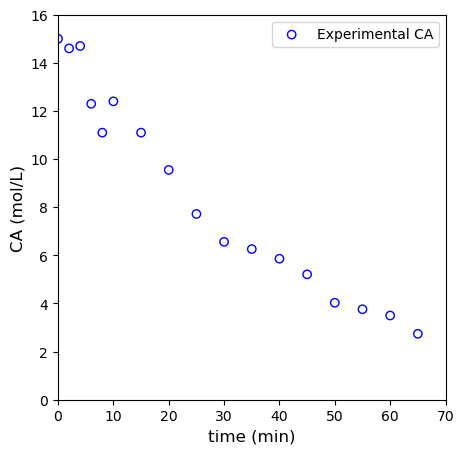

In [18]:
#####################################################################
# Add figure of CA vs. t data                                       #
#####################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Material Balance on the Batch Reactor

We know that this is a first order reaction in a constant volume batch reactor.  An appropriate material balance to model this system is:

$$\frac{dC_A}{dt} = -kC_A$$

And we know how to solve this analytically to get:

$$C_A = C_{A0}\exp(-kt)$$

So we have a nonlinear model.  We can overlay that model with a guess at the rate constant and see how well it agrees with our data.

For k = 0.01, residual sum of squares is SSE = 2.13E+02


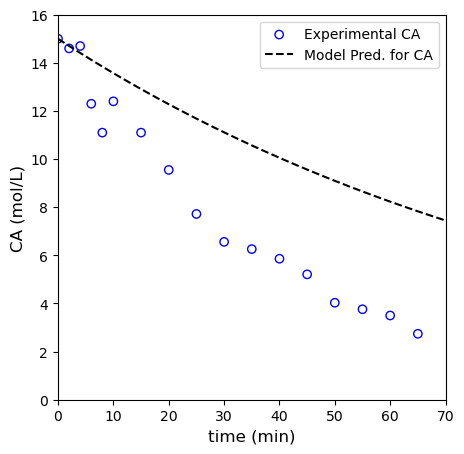

In [29]:
#######################################################################################
# Define model that describes first order reaction in a constant volume batch reactor #
#######################################################################################
CAfun = lambda k,t: CA0*np.exp(-k*t) 

#######################################################################################
# define test value of rate constant and time array to generate predictions           #
#######################################################################################

ktest = 0.01  #1/min
tmod  = np.linspace(0, 70, 100)

#######################################################################################
# Calculate SSE for ktest and experimental times                                      #
#######################################################################################
SSEtest = np.sum((CA1 - CAfun(ktest, t1))**2)
print(f'For k = {ktest:3.2f}, residual sum of squares is SSE = {SSEtest:3.2E}')

#######################################################################################
# Overlay predictions with observations using ktest                                   #
#######################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAfun(ktest, tmod), label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Using an optimization routine

As usual, we can do much better by creating an objective function and minimizing it with an optimization routine.  Here, we'll create an objective function that calculates our sum of squares as a function of our variable parameter (the rate constant), and we'll use opt.minimize_scaler to find the "best" value of the rate constant, i.e., the one that minimizes the error between our model predictions and our measurments.

In [33]:
###############################################################################################
# Define objective function -- it will take unknown parameters as arguments, here obj1(k)     #
# It will calculate SSE for the value of k passed as an argument and return SSE               #
###############################################################################################

def obj1(par):
    k     = par 
    CAexp = CA1
    CAmod = CAfun(k, t1)  #mol/L    
    SSE = np.sum(((CAexp - CAmod))**2) 
    return SSE

###############################################################################################
# Minimize SSE to find optimal k                                                              #
###############################################################################################

ans1  = opt.minimize_scalar(obj1)#, method = 'Brent', bracket = [0.001, 1])

###############################################################################################
# Store and display answers at optimum                                                        #
###############################################################################################

k_opt = ans1.x
SSE   = ans1.fun
print(ans1, '\n')
print(f'The optimum rate constant is {k_opt:3.3f} 1/min with a SSE value of {SSE}')

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 5.21951743321773
       x: 0.024798795779924145
     nit: 19
    nfev: 22 

The optimum rate constant is 0.025 1/min with a SSE value of 5.21951743321773


Now that we know the optimum value of the rate constant, we can overlay the model with our measurments and see how well it does.  It is good to get in the habit of looking at the raw residual error as it gives you an idea of whether your measurements are randomly scattered about the best fit line, or if there is systematic deviation.  We'll calculate that quanity and plot it as a function of each measurement's concentration.

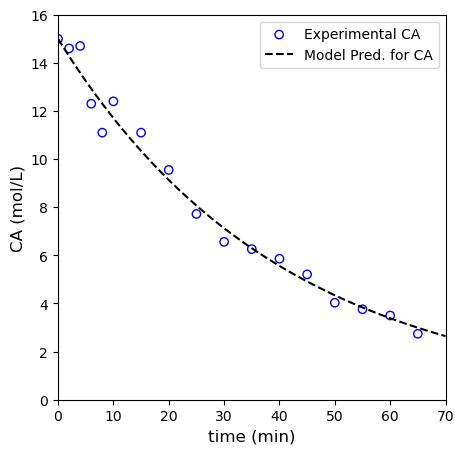

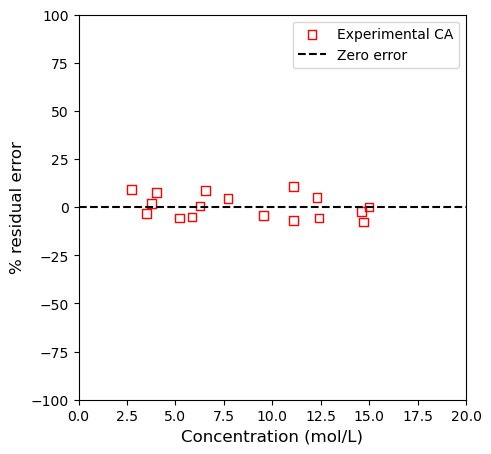

In [42]:
####################################################################################
# Calculate model result and residual error using optimum parameters               #
####################################################################################

CAmod = CAfun(k_opt, tmod)               #generate smooth curve showing model prediction as a continuous function of time
resid = (CAfun(k_opt, t1) - CA1)/CA1*100 #generate residual error at each experimental time

####################################################################################
# Overlay best fit model with measurements                                         #
####################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(t1, CA1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAmod, label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

####################################################################################
# Generate plot of residual errors                                                 #
####################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CA1, resid, marker = 's', color = 'none', edgecolor = 'red', label = 'Experimental CA')
plt.hlines(0, 0, 20, color = 'black', linestyle = 'dashed', label = 'Zero error')
plt.xlim(0, 20)
plt.ylim(-100, 100)
plt.xlabel('Concentration (mol/L)', fontsize = 12)
plt.ylabel('% residual error', fontsize = 12)
plt.legend()
plt.show()

## Example Problem 02

The two following reactions occur in a constant volume batch reactor:

\begin{align}
    2A + B \longrightarrow C \\
    B  + 2C \longrightarrow D \\
\end{align}

Both reactions follow an elementary rate law; however, we do not know either of the rate constants ($k_1$ and $k_2$), so we attempt to estimate them from data collected in our constant volume batch reactor.  The data (time in minutes and concentrations of $A$, $B$, $C$, and $D$ in moles per liter) are included in the CSV files `N45_DATA2.csv`

The initial concentrations of species $A$ and $B$ are 25 and 20 moles per liter, respectively. The initial concentrations of $C$ and $D$ are both zero.

In [44]:
CA20    = 25.0  #mol/L
CB20    = 20.0  #mol/L
CC20    = 0.0   #mol/L
CD20    = 0.0   #mol/L
DATA2df = pd.read_csv("N45_DATA2.csv")
DATA2   = pd.DataFrame.to_numpy(DATA2df)
t2      = DATA2[:, 0]
CA2     = DATA2[:, 1]
CB2     = DATA2[:, 2]
CC2     = DATA2[:, 3]
CD2     = DATA2[:, 4]
DATA2df

,time (min),CA (mol/L),CB (mol/L),CC (mol/L),CD (mol/L)
0,0.0000,24.60,18.60,0.0000,0.000000e+00
1,0.0050,22.50,20.80,0.0501,1.230000e-07
2,0.0125,24.80,19.40,0.1320,2.030000e-06
3,0.0350,25.30,20.80,0.3610,3.950000e-05
4,0.0750,22.30,17.90,0.7000,3.750000e-04
5,0.1250,20.70,17.10,1.1900,1.480000e-03
6,0.2500,19.70,19.50,1.8900,9.900000e-03
7,0.5000,16.60,16.80,3.6500,5.640000e-02
8,1.0000,13.40,15.70,4.6000,2.190000e-01
9,2.0000,11.00,12.40,6.0600,7.890000e-01


### Visualize the data

Plot the data to get a feel for what we're working with.

In [113]:
# plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.xlabel('time (min)', fontsize = 12)
# plt.ylabel('Concentration (mol/L)', fontsize = 12)
# plt.xlim(0, 70)
# plt.ylim(0, 30)
# plt.legend(['CA', 'CB', 'CC', 'CD'])
# plt.show()

### Setting up the Least Squares Problem

When we move toward the least squares analysis, we run into an issue: we can't solve this reactor model analytically as we would with a normal "integral analysis" method.  We have to integrate it numerically.  This gets a little more tricky in terms of the code.  First, let's just remember how we would solve this problem in general by solving a constant volume batch reactor for values of k1 and k2 that we will just guess.

In [114]:
# def P2a(t, var):
#     CA = var[0]
#     CB = var[1]
#     CC = var[2]
#     CD = var[3]
    
#     k1 = 0.05
#     k2 = 0.05
    
#     r1 = k1*CA**2*CB
#     r2 = k2*CB*CC**2
    
#     RA = -2*r1
#     RB = -1*r1 - 1*r2
#     RC =  1*r1 - 2*r2
#     RD =  0*r1 + 1*r2
    
#     D1 = RA
#     D2 = RB
#     D3 = RC
#     D4 = RD
#     return [D1, D2, D3, D4]

# C0     = [25, 20, 0, 0] #mol/L
# tspan  = (0, max(t2))
# ans2a  = solve_ivp(P2a, tspan, C0, atol = 1e-8, rtol = 1e-8)

# plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# #plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# #plt.semilogx(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# plt.xlabel('time (min)', fontsize = 12)
# plt.ylabel('Concentration (mol/L)', fontsize = 12)
# plt.xlim(0, 70)
# plt.ylim(0, 30)
# plt.legend(['CA', 'CB', 'CC', 'CD'])
# plt.show()

### Create a more flexible ODE function that allows us to pass parameters

But we have to be thinking more flexibly.  We need to not be setting the rate constants ourselves, but allowing an optimization routine to iteratively vary them.  We'll work through this in a couple of steps.  First, let's convert our ODE system for the batch reactor so that it will accept parameters as arguments; this will make it much easier for us to set their values to try new combinations.

In [116]:
# def P2b(t, var, par):
#     CA = var[0]
#     CB = var[1]
#     CC = var[2]
#     CD = var[3]
    
#     k1 = par[0]
#     k2 = par[1]
    
#     r1 = k1*CA**2*CB
#     r2 = k2*CB*CC**2
    
#     RA = -2*r1
#     RB = -1*r1 - 1*r2
#     RC =  1*r1 - 2*r2
#     RD =  0*r1 + 1*r2
    
#     D1 = RA
#     D2 = RB
#     D3 = RC
#     D4 = RD
#     return [D1, D2, D3, D4]

# C0     = [25, 20, 0, 0] #mol/L
# tspan  = (0, max(t2))
# par    = [1, 1]
# ans2b  = solve_ivp(P2b, tspan, C0, args = (par, ), atol = 1e-8, rtol = 1e-8)

# plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# # plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# # plt.semilogx(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# plt.xlabel('time (min)')
# plt.ylabel('Concentration (mol/L)')
# plt.xlim(0, 70)
# plt.ylim(0, 30)
# plt.legend(['CA', 'CB', 'CC', 'CD'])
# plt.show()

### Use the ODE solver to evaluate your objective function

Now, we can use that model along with the ODE solver to calculate the residual sum of squares between the model and measurments.  We'll do this first as a demo, and then we'll convert it into an objective function

In [110]:
# texp   = t2
# Cexp   = C2
# C0     = [25, 20, 0, 0] #mol/L
# tspan  = (0, max(t2))

# par0    = [0.05, 0.05]
# ans2c   = solve_ivp(P2b, tspan, C0, args = (par0, ), atol = 1e-8, rtol = 1e-8)#, t_eval = texp)
# Cmod    = ans2c.y.T

# print(Cexp)
# print(Cmod)
# SQERROR = ((Cexp - Cmod))**2
# print(Cexp.shape)
# print(Cmod.shape)
# print(SQERROR)
# print(SQERROR.shape)
# print(SQERROR.flatten())
# print(SQERROR.flatten().shape)
# SSE     = np.sum(SQERROR.flatten())
# print(SSE)

Now that we have an understanding of how we could use a numerical solution to generate model predictions at various experimental times, we can embed this in an objective function.

In [109]:
# def obj2(par):
#     texp   = t2
#     Cexp   = C2
#     C0     = [25, 20, 0, 0] #mol/L
#     tspan  = (0, max(t2))

#     ans2    = solve_ivp(P2b, tspan, C0, args = (par, ), atol = 1e-8, rtol = 1e-8, t_eval = texp)
#     Cmod    = ans2.y.T
    
#     SQERROR = ((Cexp - Cmod))**2 
#     SSE     = np.sum(SQERROR.flatten())
#     print(f'For k1 = {par[0]:8.2E} and k2 = {par[1]:8.2E}, SSE = {SSE:8.2E}')
#     return SSE

# par0  = [0.05, 0.05]
# ans2d = opt.minimize(obj2, par0)
    
# bnds  = ((0, None), (0, None))
# ans2d = opt.minimize(obj2, par0, method = 'L-BFGS-B', bounds = bnds)
# print(ans2d, '\n')
# k1_opt, k2_opt = ans2d.x
# par_opt = ans2d.x
# SSE   = ans2d.fun
# print(f'The optimum rates constant are k1 = {k1_opt:3.3E} and k2 = {k2_opt:3.3E} giving an SSE value of {SSE:3.3f}')

In [108]:
# ans2e  = solve_ivp(P2b, tspan, C0, args = (par_opt, ), atol = 1e-8, rtol = 1e-8, t_eval = t2)
# print(C2)
# print(C2.shape)
# print(ans2e.y)
# print(ans2e.y.shape)
# print(ans2e.y.T)
# print(ans2e.y.T.shape)
# resid  = (C2 - ans2e.y.T)
# nexp   = len(t2)
# expn   = np.linspace(0, nexp, nexp)

# plt.figure(figsize = (5, 5))
# plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# #plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# #plt.semilogx(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
# plt.xlabel('time (min)')
# plt.ylabel('Concentration (mol/L)')
# plt.xlim(0, 70)
# plt.ylim(0, 30)
# plt.legend(['CA', 'CB', 'CC', 'CD'])

# plt.figure(figsize = (5, 5))
# plt.plot(expn, resid, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.xlabel('Measurement Number')
# plt.ylabel('residual error')
# plt.legend(['error in CA', 'error in CB', 'error in CC', 'error in CD'], loc = 'lower right')
# plt.show()

In [101]:
# parity = [1e-7, 30]
# plt.plot(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# plt.plot(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
# #plt.loglog(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
# #plt.loglog(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
# plt.xlabel('experimental measurements', fontsize = 12)
# plt.ylabel('model predictions', fontsize = 12)
# plt.show()